In [107]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import requests
import datetime

%load_ext autoreload
%autoreload 2

import ptvsd
ptvsd.enable_attach()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('0.0.0.0', 5678)

In [179]:
from access_treasurydirectgov import *
import bond_analytics as ba
from db_manager_UST import *

In [131]:
date_range = pd.date_range(start='2020/08/06', end='2020/08/16', freq='D')

In [181]:
dn = db_manager_UST()

In [192]:
df = dn.retrieve_as_of(datetime.datetime(2020,8,6))

In [215]:
df_p = df[df['type'].isin(['Note', 'Bond'])]

In [216]:
ttm = (df_p['maturityDate'] - df_p['date']).dt.days / 365.0

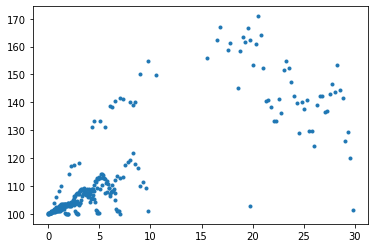

In [217]:
plt.figure()
plt.plot(ttm, df_p['endOfDay'], '.')
plt.show()

In [198]:
df['securityTerm'].value_counts()

30-Year            84
7-Year             84
5-Year             62
10-Year            60
3-Year             35
2-Year             30
26-Week            19
154-Day            18
52-Week            13
20-Year             5
105-Day             3
30-Year 3-Month     2
29-Year 9-Month     2
103-Day             1
30-Year 6-Month     1
20-Year 6-Month     1
Name: securityTerm, dtype: int64

In [202]:
df[df['securityTerm'] == '20-Year 6-Month']

,cusip,buy,sell,endOfDay,date,issueDate,securityType,securityTerm,maturityDate,interestRate,interestPaymentFrequency,spread,type
381,912810FR4,117.109375,117.03125,116.96875,2020-08-06,2004-07-30,Bond,20-Year 6-Month,2025-01-15,0.02375,Semi-Annual,0.0,TIPS


In [203]:
get_cusip_info('912810FR4')[1]

[{'cusip': '912810FR4',
  'issueDate': datetime.datetime(2004, 7, 30, 0, 0),
  'securityType': 'Bond',
  'securityTerm': '20-Year 6-Month',
  'maturityDate': datetime.datetime(2025, 1, 15, 0, 0),
  'interestRate': 0.02375,
  'refCpiOnIssueDate': '189.029030',
  'refCpiOnDatedDate': '188.496770',
  'announcementDate': '2004-07-22T00:00:00',
  'auctionDate': '2004-07-27T00:00:00',
  'auctionDateYear': '2004',
  'datedDate': '2004-07-15T00:00:00',
  'accruedInterestPer1000': '',
  'accruedInterestPer100': '',
  'adjustedAccruedInterestPer1000': '0.9708000000',
  'adjustedPrice': '98.7580000000',
  'allocationPercentage': '8.830000',
  'allocationPercentageDecimals': '2',
  'announcedCusip': '',
  'auctionFormat': 'Single-Price',
  'averageMedianDiscountRate': '',
  'averageMedianInvestmentRate': '',
  'averageMedianPrice': '0.000',
  'averageMedianDiscountMargin': '',
  'averageMedianYield': '2.380000',
  'backDated': 'Yes',
  'backDatedDate': '',
  'bidToCoverRatio': '1.490000',
  'callD

In [178]:
df = read_hist_data_from_treasurydirectgov(datetime.datetime(2008,6,2))
df

,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY
0,912795E72,,0.000%,,,0.000000,99.984917,99.989889
1,912795E80,,0.000%,,,99.948333,99.948056,99.954000
2,912795E98,,0.000%,,,99.908861,99.908389,99.914222
3,912795F22,,0.000%,,,99.871000,99.870667,99.877333
4,912795F30,,0.000%,,,99.836389,99.835528,99.843333
...,...,...,...,...,...,...,...,...
216,912828HX1,,0.000%,,,99.312500,99.312500,99.375000
217,912828HY9,,0.000%,,,99.203125,99.187500,99.312500
218,912828HZ6,,0.000%,,,99.046875,99.031250,99.218750
219,912828JA9,,0.000%,,,100.187500,100.187500,100.218750


In [172]:
df

In [22]:
adf = []
for dt in date_range:
    print(dt)
    try:
        df = read_hist_data_from_treasurydirectgov(dt)
    except Exception as ex:
        print(ex)
        continue
    df['Date'] = dt
    adf.append(df)
df_a = pd.concat(adf)        

2005-07-20 00:00:00
2005720: failed to retrieve data
2005-07-21 00:00:00
2005721: failed to retrieve data
2005-07-22 00:00:00
2005722: failed to retrieve data
2005-07-25 00:00:00
2005725: failed to retrieve data
2005-07-26 00:00:00
2005726: failed to retrieve data
2005-07-27 00:00:00
2005727: failed to retrieve data
2005-07-28 00:00:00
2005728: failed to retrieve data
2005-07-29 00:00:00
time data '' does not match format '%m/%d/%Y' (match)


ValueError: No objects to concatenate

In [7]:
df_note = df_a[df_a['SECURITY TYPE'].isin(['MARKET BASED NOTE', 'MARKET BASED BOND'])].copy()

11

In [41]:
df[['CUSIP','SECURITY TYPE','RATE', 'MATURITY DATE']].T.to_dict()[33]['MATURITY DATE']

Timestamp('2020-11-27 00:00:00')

In [9]:
def calc_yield(row):
    dt_start = datetime.datetime(2019,1,1)
    dt_end = row['MATURITY DATE']
    coupon = row['RATE']
    today = row['Date']
    price = row['END OF DAY']
    if price < 0.01:
        price = 0.5*(row['BUY'] + row['SELL'])
    
    b = ba.USConventional(row['SECURITY TYPE'], dt_start, dt_end, coupon)
    y = b.get_yield(today, price)
    
    return y

df_note['Yield'] = df_note.apply(calc_yield, axis = 1)

In [10]:
df_note_dt = df_note[df_note['Date'] == '2020-07-30']

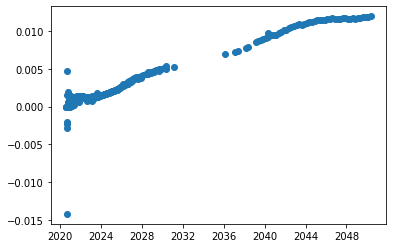

In [11]:
df_p = df_note_dt
plt.figure()
x = df_p['MATURITY DATE']
y = df_p['Yield']
plt.plot(x, y, 'o')
plt.show()

In [39]:
import pymongo

In [40]:
myclient = pymongo.MongoClient('mongodb://localhost:27017/')

In [41]:
mydb = myclient['mydatabase']

In [42]:
myclient.list_database_names()

['admin', 'config', 'local']

In [43]:
mycol = mydb['customers']

In [45]:
x = mycol.find_one()

In [48]:
print(x)

None


In [17]:
print(mydb.list_collection_names())

['customers']


In [18]:
collist = mydb.list_collection_names()
if "customers" in collist:
  print("The collection exists.")

The collection exists.


In [19]:
mydict = {'name':'john', 'address':'highway 37'}
x = mycol.insert_one(mydict)

In [21]:
mycol.find_one()

{'_id': ObjectId('5f25766bc8cab274b64fe693'),
 'name': 'john',
 'address': 'highway 37'}

In [130]:
collist = mydb.list_collection_names()
if "customers" in collist:
  print("The collection exists.")

The collection exists.


In [131]:
x.inserted_id

ObjectId('5f25766bc8cab274b64fe693')

In [138]:
mycol.insert_many(df_note.to_dict(orient = 'records'))

In [154]:
pd.DataFrame(mycol.find({'BUY':{'$lt':0.1}}, {'_id':0}))

,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY,Date,Yield
0,912828Y46,MARKET BASED NOTE,0.02625,2020-07-31,,0.0,100.06250,100.06250,2020-07-20,0.000823
1,912828XM7,MARKET BASED NOTE,0.01625,2020-07-31,,0.0,100.03125,100.03125,2020-07-20,0.003517
2,912828VP2,MARKET BASED NOTE,0.02000,2020-07-31,,0.0,100.03125,100.03125,2020-07-20,0.007234
3,9128282Q2,MARKET BASED NOTE,0.01500,2020-08-15,,0.0,100.09375,100.09375,2020-07-20,0.000644
4,912828NT3,MARKET BASED NOTE,0.02625,2020-08-15,,0.0,100.15625,100.15625,2020-07-20,0.002208
...,...,...,...,...,...,...,...,...,...,...
262,912828A83,MARKET BASED NOTE,0.02375,2020-12-31,,0.0,100.90625,0.00000,2020-07-31,2.676000
263,912828N48,MARKET BASED NOTE,0.01750,2020-12-31,,0.0,100.65625,0.00000,2020-07-31,2.679117
264,9128285S5,MARKET BASED NOTE,0.02500,2020-12-31,,0.0,100.96875,0.00000,2020-07-31,2.674672
265,9128283Q1,MARKET BASED NOTE,0.02000,2021-01-15,,0.0,100.84375,0.00000,2020-07-31,2.330970
